<a href="https://colab.research.google.com/github/dainilliniad/small311qlab/blob/neurowave/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import torch #
import torchvision #
import matplotlib.pyplot as plt #
from time import time #
from torchvision import datasets, transforms #
from google.colab import drive #
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader #
from tqdm import tqdm #
from torch.autograd import Variable #
import torch.nn as nn #
from torch import tensor
import random
import matplotlib
drive.mount('/content/gdrive')
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

Mounted at /content/gdrive


In [3]:
correlation1=np.load('/content/cor1.npy') #тут указать свой путь до
correlation2=np.load('/content/cor2.npy')
correlation3=np.load('/content/cor3.npy')
pitog=np.load('/content/pitog.npy')
tetta=np.load('/content/tetitog.npy')   #файлов numpy, созданных в первой части проекта

In [4]:
class LAADataset(Dataset): #создание датасетов из наших файлов
    def __init__(self, Corr_data_g1, Corr_data_g2, Corr_data_g3, Theta_data, P_data, x_0, x_end):
      self.LAAdata = []
      self.len_data = x_end-x_0
      for obj in tqdm(range(self.len_data)):
        self.LAAdata.append((tensor([Corr_data_g1[obj],Corr_data_g2[obj],Corr_data_g3[obj]]),tensor([(Theta_data[obj]+np.exp(1)/2)/np.exp(1),P_data[obj]/0.9])))

    def __len__(self):
      return self.len_data

    def __getitem__(self, idx):
      return self.LAAdata[idx][0],self.LAAdata[idx][1]

In [22]:
set_random_seed(42)
#объявление модели, число нейронов в слоях
model = torch.nn.Sequential(
        torch.nn.Linear(3, 50, bias=False),
        nn.BatchNorm1d(50),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 600, bias=False),
        nn.BatchNorm1d(600),
        torch.nn.ReLU(),

        torch.nn.Linear(600, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 100, bias=False),
        nn.BatchNorm1d(100),
        torch.nn.ReLU(),

        torch.nn.Linear(100, 25, bias=False),
        nn.BatchNorm1d(25),
        torch.nn.ReLU(),

        torch.nn.Linear(25, 2),
        torch.nn.Sigmoid()
        )

In [23]:
set_random_seed(42)
# Длина обучающей и тестирующей выборок
lenTestData = 1000 #длина тестовой выборки
lenTrainData = 14500 #длина обучающей выборки
batch_size = 400 #размер батча
epoches=10 #чило эпох
criterion = torch.nn.MSELoss() #критерий оптимизации ошибки - среднеквадратический
optimizer = torch.optim.Adam(model.parameters(), lr=(1e-5)*3)  #шаг спуска - 10^-4

testDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog, 0,lenTestData)
trainDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog,lenTestData,lenTrainData+lenTestData)

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 14500/14500 [00:00<00:00, 18060.52it/s]


In [24]:
set_random_seed(42)
#обучение модели по эпохам
model = model.float()
loss_train = []
loss_test = []
loss_train_tet = []
loss_test_tet = []
loss_train_p = []
loss_test_p = []

for epoch in range(epoches):
  model.train()
  for corf, tettab in trainDataloader:

    tettab = tettab.float()
    output = model(corf.float()) #получаем результат
    loss = criterion(output, tettab)  #считаем ошибку по критерию
    loss_tetta=criterion(output[0], tettab[0]) #считаем ошибку тетта по критерию
    loss_p=criterion(output[1], tettab[1]) #считаем ошибку p по критерию

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train.append(loss.item())
  loss_train_tet.append(loss_tetta.item())
  loss_train_p.append(loss_p.item())

  model.eval()
  for corf, tettab in testDataloader:  #тоже самое, только для тестовой выборки
    tettab = tettab.float()
    output = model(corf.float())
    loss = criterion(output, tettab)
    loss_tetta=criterion(output[0], tettab[0])
    loss_p=criterion(output[1], tettab[1])

  loss_test.append(loss.item())
  loss_test_tet.append(loss_tetta.item())
  loss_test_p.append(loss_p.item())
  print('Epoch: ', epoch, 'Loss: ', loss.item())

Epoch:  0 Loss:  0.07800402492284775
Epoch:  1 Loss:  0.023734277114272118
Epoch:  2 Loss:  0.0173890832811594
Epoch:  3 Loss:  0.014089841395616531
Epoch:  4 Loss:  0.013631983660161495
Epoch:  5 Loss:  0.012565387412905693
Epoch:  6 Loss:  0.012414325028657913
Epoch:  7 Loss:  0.011476722545921803
Epoch:  8 Loss:  0.011478754691779613
Epoch:  9 Loss:  0.011158907786011696
Epoch:  10 Loss:  0.01100237388163805
Epoch:  11 Loss:  0.010728172026574612
Epoch:  12 Loss:  0.010718071833252907
Epoch:  13 Loss:  0.010034439153969288
Epoch:  14 Loss:  0.010074607096612453


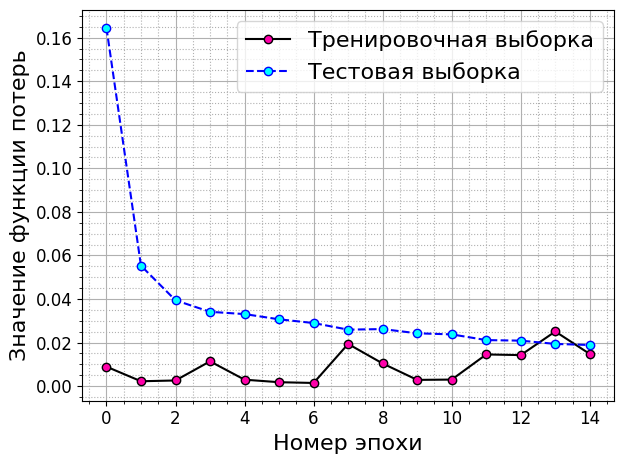

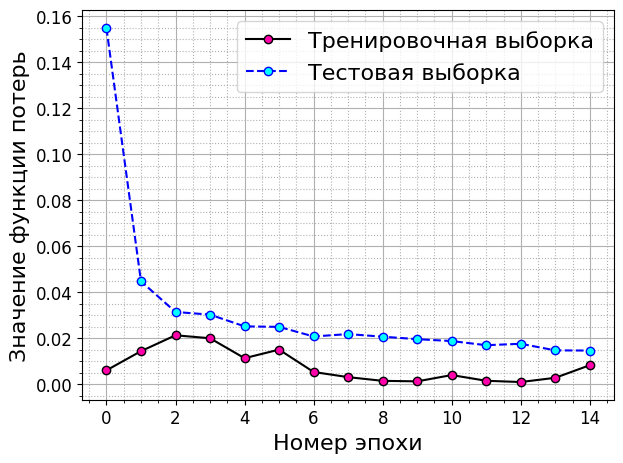

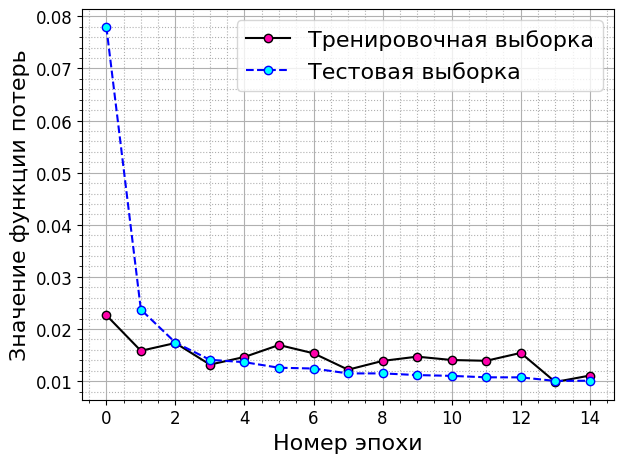

In [25]:
def plotLoss(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k',
         markerfacecolor='#ff00aaff', label='Тренировочная выборка')
  ax.plot(localtest, linestyle='--', marker='o', color='b',
         markerfacecolor='#00ffffff',  label='Тестовая выборка')
  ax.legend(fontsize=16)
  ax.minorticks_on()
  ax.set_xlabel('Номер эпохи', fontsize=16)
  ax.set_ylabel(r'Значение функции потерь', fontsize=16)
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

plotLoss(loss_test_p,loss_train_p,'loss')
plotLoss(loss_test_tet,loss_train_tet,'loss')
plotLoss(loss_test,loss_train,'loss')

<ipython-input-58-17a00fdf5c00>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tet=torch.tensor((tet*np.exp(1))-np.exp(1)/2*torch.ones(7,7))  #переводим в тензоры


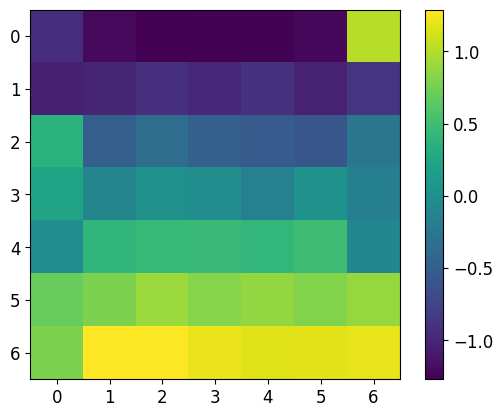

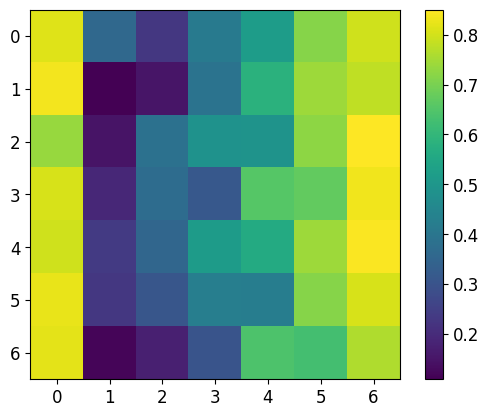

tensor([[-0.9341, -1.2063, -1.2695, -1.2563, -1.2515, -1.2165,  1.0092],
        [-1.0415, -1.0055, -0.9168, -0.9735, -0.9091, -1.0295, -0.8883],
        [ 0.3599, -0.4902, -0.3584, -0.4812, -0.5373, -0.5810, -0.2696],
        [ 0.2253, -0.1032,  0.0162, -0.0122, -0.1585,  0.0349, -0.1639],
        [-0.0139,  0.4177,  0.4456,  0.4641,  0.4274,  0.4984, -0.0842],
        [ 0.6970,  0.7807,  0.9010,  0.8270,  0.8756,  0.8054,  0.8821],
        [ 0.7810,  1.2889,  1.2821,  1.2159,  1.1633,  1.1838,  1.1953]])
tensor([[0.8145, 0.3587, 0.2287, 0.4128, 0.5196, 0.7166, 0.7975],
        [0.8385, 0.1094, 0.1506, 0.3906, 0.5820, 0.7431, 0.7781],
        [0.7353, 0.1490, 0.3849, 0.4867, 0.4900, 0.7246, 0.8502],
        [0.8050, 0.1917, 0.3718, 0.3144, 0.6540, 0.6721, 0.8331],
        [0.7977, 0.2364, 0.3537, 0.5154, 0.5630, 0.7407, 0.8447],
        [0.8249, 0.2299, 0.3073, 0.4269, 0.4227, 0.7162, 0.8041],
        [0.8201, 0.1198, 0.1754, 0.3015, 0.6431, 0.6277, 0.7607]])


In [ ]:
length=7  #длина изображение, примем 7, длина равна ширине
width=length   #ширина изображение, примем квадратным, длина равна ширине
x=[[0.1715, 0.0357, 0.0241, 0.0527, 0.0790, 0.1370, 0.1802],
        [0.1883, 0.0748, 0.0862, 0.1159, 0.1651, 0.1935, 0.1906],
        [0.2154, 0.2078, 0.2288, 0.2222, 0.1937, 0.2344, 0.2388],
        [0.2434, 0.2378, 0.2699, 0.2847, 0.2671, 0.2625, 0.2412],
        [0.2356, 0.2011, 0.1923, 0.2097, 0.2305, 0.2247, 0.2519],
        [0.2231, 0.1101, 0.0996, 0.1324, 0.1272, 0.1907, 0.2016],
        [0.1993, 0.0008, 0.0183, 0.0570, 0.1155, 0.1121, 0.1556]]
y=[[0.1839, 0.1244, 0.0921, 0.1049, 0.1131, 0.1431, 0.2267],
        [0.1873, 0.0041, 0.0360, 0.0537, 0.0673, 0.1102, 0.1477],
        [0.2140, 0.0158, 0.0748, 0.0691, 0.0859, 0.1182, 0.1985],
        [0.2293, 0.1064, 0.1392, 0.1243, 0.1594, 0.1925, 0.2008],
        [0.2024, 0.2129, 0.1935, 0.2285, 0.2502, 0.2533, 0.2068],
        [0.2536, 0.2729, 0.2650, 0.2686, 0.2489, 0.2420, 0.2345],
        [0.2257, 0.1919, 0.1711, 0.1950, 0.2077, 0.2125, 0.2311]]
z=[[0.2321, 0.2219, 0.2269, 0.2310, 0.2367, 0.2551, 0.2359],
        [0.2590, 0.1481, 0.1133, 0.1628, 0.1850, 0.2461, 0.2157],
        [0.1577, 0.0585, 0.0599, 0.1002, 0.0932, 0.1759, 0.2056],
        [0.1734, 0.0127, 0.0416, 0.0345, 0.1166, 0.1123, 0.1901],
        [0.1655, 0.0592, 0.0893, 0.1109, 0.1098, 0.1620, 0.1993],
        [0.2047, 0.1491, 0.1758, 0.1659, 0.1695, 0.1884, 0.2140],
        [0.2262, 0.2343, 0.2496, 0.2200, 0.2430, 0.2369, 0.2457]]
#x, y, z - 3 корреляционные функции g1, g2, g3 которые тестируем на сетке
t=[]
for i in range(length):
  for j in range(width):
    t.append([x[i][j], y[i][j], z[i][j]])

model1=model(torch.tensor(t))
p=[]
tet=[]
p1=[]
tet1=[]
for i in range(length*width):
  if len(p1)!=length:
     p1.append(float(model1[i][1]))
     tet1.append(float(model1[i][0]))
  else:
    p.append(p1)
    tet.append(tet1)
    p1=[]
    tet1=[]
    p1.append(float(model1[i][1]))
    tet1.append(float(model1[i][0]))
p.append(p1)
tet.append(tet1)

p=torch.tensor(p)*0.9  #переводим в тензоры
tet=torch.tensor(tet)
tet=torch.tensor((tet*np.exp(1))-np.exp(1)/2*torch.ones(7,7))  #переводим в тензоры

plt.imshow(tet)
plt.colorbar()
plt.show()
plt.imshow(p)
plt.colorbar()
plt.show()
print(tet)
print(p)